In [1]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

sns.set_style("darkgrid")
sns.set(font_scale=1.5)
%matplotlib inline

In [2]:
def execute_query(query):
    engine = create_engine('sqlite:///./../../data/processed/airlines.db')
    with engine.connect() as conn:
        features = pd.read_sql(query, conn)
        
    return features

def save_figure(figure_name):
    plt.savefig(f"../../reports/figures/{figure_name}", bbox_inches='tight')

# EDA

In [3]:
departure_status = """
    SELECT
        f.departure_status as departure_status,
        f.year,
        f.month,
        SUM(f.flights) as flights
    FROM
        flights as f
    GROUP BY 
        f.departure_status, f.year, f.month
"""
#departure_delays = execute_query(departure_status)

In [4]:
path_to_csv = './../../data/processed/flights-departures-by-category-by-month.csv'
#departure_delays.to_csv('./../../data/processed/flights-departures-by-category-by-month.csv')
departure_delays = pd.read_csv(path_to_csv)

def prepare_departure_data(data):
    # Provide human readable labels
    display_label_map = {
        'EARLY': 'Early', 
        'ON_TIME': 'On-Time', 
        'DELAYED_15_TO_30': 'Delayed 15 to 30 Minutes', 
        'DELAYED_31_TO_60': 'Delayed 31 to 60 Minutes', 
        'DELAYED_61_TO_120': 'Delayed 61 to 120 Minutes', 
        'DELAYED_120_PLUS': 'Delayed 120+ Minutes', 
        'CANCELLED': 'Cancelled'
    }
    data['label'] = data['departure_status'].map(display_label_map)
    data['day'] = 1
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

    return data[['date', 'departure_status', 'label', 'flights']]

departure_delays = prepare_departure_data(departure_delays)
departure_delays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
date                504 non-null datetime64[ns]
departure_status    505 non-null object
label               505 non-null object
flights             504 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 15.9+ KB


In [5]:
departure_delays.head()

,date,departure_status,label,flights
0,2012-01-01,CANCELLED,Cancelled,7104.0
1,2012-02-01,CANCELLED,Cancelled,4661.0
2,2012-03-01,CANCELLED,Cancelled,5410.0
3,2012-04-01,CANCELLED,Cancelled,4961.0
4,2012-05-01,CANCELLED,Cancelled,4479.0


In [6]:
# How many flights are represented in the data?
def calculate_total_flights(data):
     return int(data.flights.sum())

total_flights = calculate_total_flights(departure_delays)
print("{:,} flights are represented in the data".format(total_flights))

35,397,413 flights are represented in the data


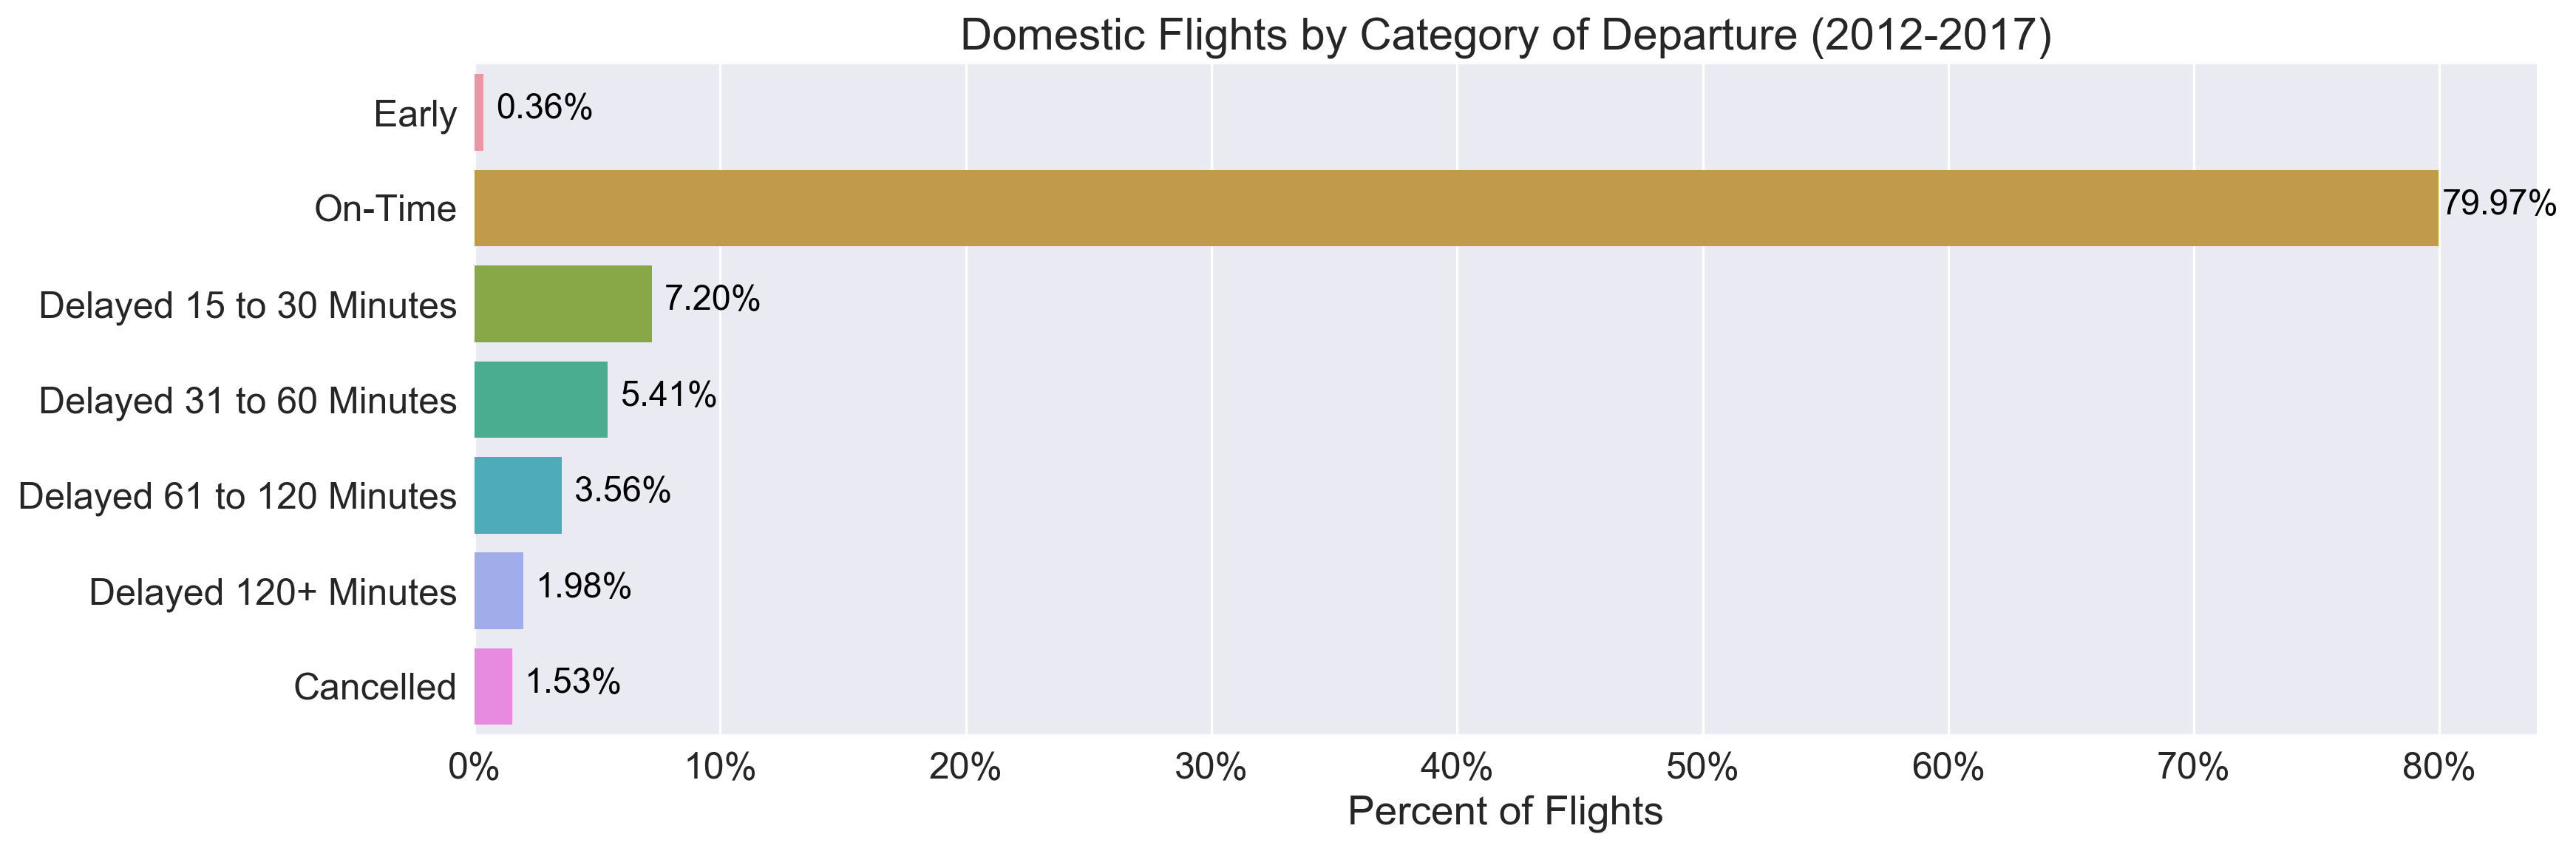

In [7]:
from matplotlib.ticker import PercentFormatter

# How are departures distributed by category?
def generate_category_distribution_plot(data):
    total_flights = calculate_total_flights(data)
    category_ratios = (data.groupby(['departure_status', 'label'])['flights'].sum() / total_flights)
    category_ratios = category_ratios.reset_index()
    
    # Order categories for plot
    order_map = {
        'EARLY': 0, 
        'ON_TIME':1, 
        'DELAYED_15_TO_30':2, 
        'DELAYED_31_TO_60':3, 
        'DELAYED_61_TO_120':4, 
        'DELAYED_120_PLUS': 5, 
        'CANCELLED':6
    }
    
    category_ratios['order'] = category_ratios['departure_status'].map(order_map)
    category_ratios = category_ratios.sort_values('order')
    
    fig, ax = plt.subplots(figsize=(15, 5), dpi=240)
    g = sns.barplot(data=category_ratios,  y='label', x='flights', ax=ax)
        
    for p in ax.patches:
        
        x_pos = p.get_x() + p.get_width() + 0.025
        y_pos = p.get_y() + p.get_height() / 1.5
        value = "{0:.2f}%".format(p.get_width() * 100)
        _ = ax.text(x_pos, y_pos, value, fontsize=14, color='black', ha='center', va='bottom')
    
    
    plt.title("Domestic Flights by Category of Departure (2012-2017)")
    plt.ylabel("")
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1)) 
    plt.xlabel("Percent of Flights")
    save_figure('flights-by-departure-category.png')
    plt.show()

generate_category_distribution_plot(departure_delays)

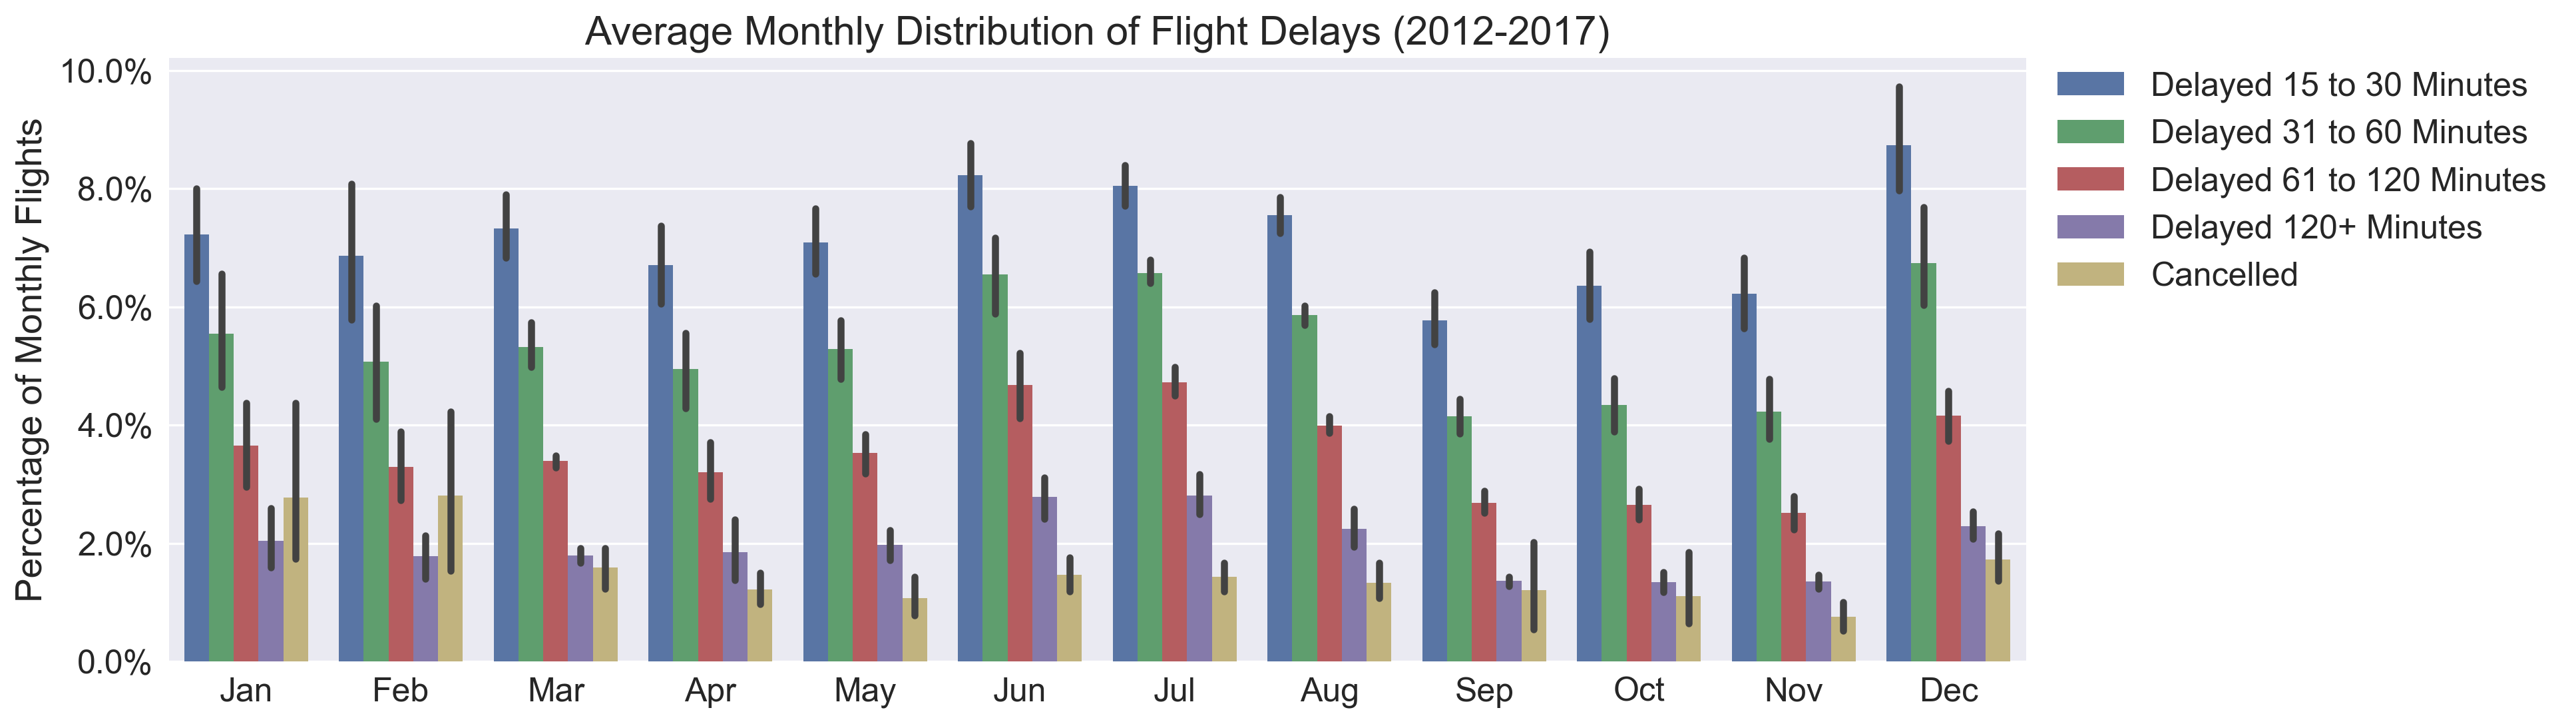

In [8]:
from matplotlib.ticker import PercentFormatter
import calendar
import numpy as np

def generate_monthly_percentage_plot(data):
    # Calculate Total Flights By Month
    total_monthly_flights = data.groupby('date').sum()['flights'].rename('monthly_totals').reset_index()
    
    # Create Monthly Totals By Category
    categories_by_month = data.groupby(['date', 'label']).sum().reset_index()
    
    # Merge dataframes
    m = pd.merge(left=categories_by_month, right=total_monthly_flights, left_on='date', right_on='date')
    
    # Calculate categorical fraction of total by month
    m['fraction'] = m['flights'] / m['monthly_totals']
    
    # Generate 'month' column for grouping by seaborn
    m['month'] = m['date'].dt.month
    
    # drop 'on-time' and 'early'
    boolean_filter = (m['label'] != 'On-Time') & (m['label'] != 'Early')
    m = m[boolean_filter]
    
    hue_order = ['Delayed 15 to 30 Minutes', 'Delayed 31 to 60 Minutes', 'Delayed 61 to 120 Minutes',
                 'Delayed 120+ Minutes', 'Cancelled']
    
    fig, ax = plt.subplots(figsize=(15, 5), dpi=240)
    sns.barplot(data=m, x='month', y='fraction', hue='label', hue_order=hue_order, ax=ax)
    
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    
    #
    plt.xlabel
    
    # Format axis labels
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1)) 
    plt.xticks(np.arange(12), calendar.month_abbr[1:13], rotation=0)
    plt.title('Average Monthly Distribution of Flight Delays (2012-2017)')
    plt.ylabel('Percentage of Monthly Flights')
    plt.xlabel('')
    save_figure('departure-categories-by-month.png')
    plt.show()
    
generate_monthly_percentage_plot(departure_delays)